In [1]:
# Los datos .csv contienen a todos los robots por ende es necesario filtrarlo
def robot_filter(robot_id, team, df):
    robot_data = df[(df['RobotID'] == robot_id) & (df['Team'] == team)]
    robot_data = robot_data[["ElapsedTime", "Pos_X","Pos_Y","Orientation", "Vx_Command","Vy_Command","Vx_Actual","Vy_Actual","Angular_Command"]]
    robot_data = robot_data.rename(columns={'Pos_X': 'x',
                                            'Pos_Y':'y',
                                            'Orientation':'theta',
                                            'Vx_Actual':'vx',
                                            'Vy_Actual':'vy',
                                            'Angular_Command':'omega_cmd',
                                            "Vx_Command":"vx_cmd",
                                            "Vy_Command":"vy_cmd"})
    return robot_data

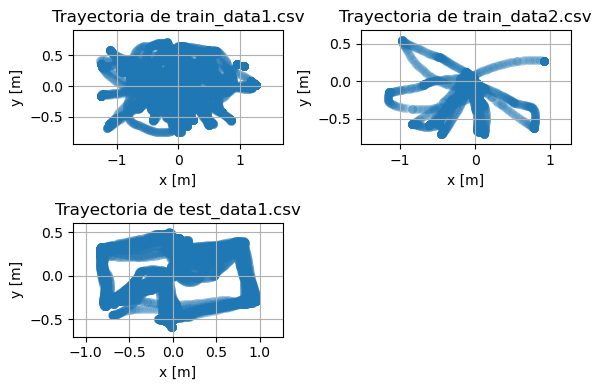

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_named_trajectories(filenames, rows, cols, robot_id=0, team=0):
    fig, axes = plt.subplots(rows, cols, figsize=(6, 4))
    axes = axes.flatten()

    for ax, fname in zip(axes, filenames):
        df = pd.read_csv(fname)
        df = robot_filter(robot_id, team, df)

        ax.scatter(df['x'], df['y'], marker='o', linewidth=0.2, alpha = 0.2)
        ax.set_title(f"Trayectoria de {fname}")
        ax.set_xlabel("x [m]")
        ax.set_ylabel("y [m]")
        ax.axis('equal')
        ax.grid(True)

    # Oculta subplots vacíos si hay más espacios que archivos
    for j in range(len(filenames), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_named_trajectories(
    filenames=["train_data1.csv", "train_data2.csv", "test_data1.csv"],
    rows=2,
    cols=2
)

In [3]:
import numpy as np

class ExtendedKalmanFilter:
    def __init__(self, initial_state, initial_covariance, process_noise, measurement_noise):
        """
        Initializes the EKF with initial state and covariance.
        State: [x, y, sin(θ), cos(θ), vx, vy, ω]
        """
        self.x = initial_state
        self.P = initial_covariance
        self.Q = process_noise
        self.R = measurement_noise

    def f(self, x, dt):
        """
        Motion model with orientation represented by sin(θ), cos(θ).
        """
        sin_theta, cos_theta, vx, vy, omega = x[2], x[3], x[4], x[5], x[6]
        theta = np.arctan2(sin_theta, cos_theta)
        theta += omega * dt  # update orientation

        new_x = x.copy()
        new_x[0] += vx * dt
        new_x[1] += vy * dt
        new_x[2] = np.sin(theta)
        new_x[3] = np.cos(theta)
        # vx, vy, omega unchanged
        return new_x

    def h(self, x):
        """
        Measurement model: returns [x, y, θ] from [x, y, sin(θ), cos(θ), ...]
        """
        theta = np.arctan2(x[2], x[3])
        return np.array([x[0], x[1], theta])

    def jacobian_f(self, x, dt):
        """
        Jacobian of motion model f w.r.t. state x.
        Approximate linearized model.
        """
        F = np.eye(7)
        F[0, 4] = dt  # ∂x/∂vx
        F[1, 5] = dt  # ∂y/∂vy

        theta = np.arctan2(x[2], x[3])
        omega = x[6]
        theta_new = theta + omega * dt
        F[2, 6] = dt * np.cos(theta_new)  # ∂sin(θ)/∂ω
        F[3, 6] = -dt * np.sin(theta_new)  # ∂cos(θ)/∂ω

        return F

    def jacobian_h(self, x):
        """
        Jacobian of measurement model h w.r.t. state x.
        """
        H = np.zeros((3, 7))
        H[0, 0] = 1  # ∂x_meas/∂x
        H[1, 1] = 1  # ∂y_meas/∂y

        sin_theta = x[2]
        cos_theta = x[3]
        denom = sin_theta**2 + cos_theta**2
        H[2, 2] = cos_theta / denom  # ∂θ/∂sin(θ)
        H[2, 3] = -sin_theta / denom  # ∂θ/∂cos(θ)

        return H

    def predict(self, dt):
        """
        EKF prediction step.
        """
        F = self.jacobian_f(self.x, dt)
        self.x = self.f(self.x, dt)
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z):
        """
        EKF update step with measurement z.
        """
        H = self.jacobian_h(self.x)
        y = z - self.h(self.x)
        y[2] = (y[2] + np.pi) % (2 * np.pi) - np.pi  # wrap θ error

        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(len(self.x)) - K @ H) @ self.P

    def get_state(self):
        return self.x

    def get_covariance(self):
        return self.P

In [4]:
import numpy as np

def compute_velocity(position_series, dt=1/60):
    """
    Computes velocity using explicit finite differences from a position time series.

    Parameters:
        position_series (array-like): Smoothed position values (e.g., x or y)
        dt (float): Time step between samples (default 1/60 for 60Hz)

    Returns:
        velocity_series (np.ndarray): Estimated velocity
    """
    position_array = np.asarray(position_series)
    N = len(position_array)
    velocity = np.zeros(N)

    for i in range(N):
        if i == 0:
            # Forward difference for the first point
            velocity[i] = (position_array[i + 1] - position_array[i]) / dt
        elif i == N - 1:
            # Backward difference for the last point
            velocity[i] = (position_array[i] - position_array[i - 1]) / dt
        else:
            # Central difference for interior points
            velocity[i] = (position_array[i + 1] - position_array[i - 1]) / (2 * dt)

    return velocity


def compute_angular_velocity(orientation_series, dt=1/60):
    """
    Computes angular velocity using finite difference from an angle time series.
    Handles wraparound automatically via np.unwrap.

    Parameters:
        orientation_series (array-like): Smoothed angles (in radians)
        dt (float): Time step between samples (default 1/60 for 60Hz)

    Returns:
        angular_velocity_series (np.ndarray): Estimated angular velocity in rad/s
    """
    theta = np.unwrap(orientation_series)
    omega = np.gradient(theta, dt)
    return omega

In [5]:
import numpy as np
import pandas as pd

def initialize_ekf(df):
    """Inicializa el estado, la covarianza y el EKF"""
    pos_x = df['x'].values
    pos_y = df['y'].values
    orientations = df['theta'].values  # en radianes

    initial_state = np.array([
        pos_x[0],
        pos_y[0],
        np.sin(orientations[0]),
        np.cos(orientations[0]),
        0.0,  # vx
        0.0,  # vy
        0.0   # omega
    ])

    initial_cov = np.diag([1e-7] * 4 + [1.0, 1.0, 1.0])
    process_noise = np.diag([1e-7, 1e-7, 1e-4, 1e-4, 1e-4, 1e-4, 1e-2])
    measurement_noise = np.diag([1e-6, 1e-6, 1e-6])

    ekf = ExtendedKalmanFilter(initial_state, initial_cov, process_noise, measurement_noise)
    return ekf

def run_ekf_filter(df, ekf, dt=0.016):
    """Ejecuta el filtro de Kalman y retorna el DataFrame con las estimaciones"""
    pos_x = df['x'].values
    pos_y = df['y'].values
    orientations = df['theta'].values

    est_tetha, est_vx, est_vy, est_omega = [], [], [], []
    est_x, est_y = [], []

    for i in range(len(df)):
        ekf.predict(dt)
        z = np.array([pos_x[i], pos_y[i], orientations[i]])
        ekf.update(z)

        state = ekf.get_state()
        est_tetha.append(np.arctan2(state[2], state[3]))
        est_vx.append(state[4])
        est_vy.append(state[5])
        est_omega.append(state[6])
        est_x.append(state[0])
        est_y.append(state[1])

    # Guardar en el DataFrame
    df_out = df.copy()
    df_out['filtered_theta'] = est_tetha
    df_out['vx'] = est_vx
    df_out['vy'] = est_vy
    df_out['omega'] = est_omega
    df_out['filtered_x'] = est_x
    df_out['filtered_y'] = est_y

    return df_out

def ekf_filter(df, dt=0.016):
    ekf = initialize_ekf(df)
    return run_ekf_filter(df, ekf, dt)

In [6]:
def transform_global_to_local(df):
    df = df.copy()

    cos_theta = np.cos(df['filtered_theta'].values)
    sin_theta = np.sin(df['filtered_theta'].values)

    vx = df['vx'].values
    vy = df['vy'].values

    # Rotation: global → local
    df['vx'] = cos_theta * vx + sin_theta * vy
    df['vy'] = -sin_theta * vx + cos_theta * vy

    return df

In [17]:
def transform_local_to_global(df):
    """
    Transforms local command velocities (vx_cmd, vy_cmd) to the global frame
    using the robot's orientation.
    """
    df = df.copy()

    cos_theta = np.cos(df['filtered_theta'].values)
    sin_theta = np.sin(df['filtered_theta'].values)

    vx_cmd_local = df['vx_cmd'].values
    vy_cmd_local = df['vy_cmd'].values

    # Rotation: Local → Global
    # v_gx = v_lx * cos(theta) - v_ly * sin(theta)
    # v_gy = v_lx * sin(theta) + v_ly * cos(theta)
    df['vx_cmd'] = vx_cmd_local * cos_theta - vy_cmd_local * sin_theta
    df['vy_cmd'] = vx_cmd_local * sin_theta + vy_cmd_local * cos_theta

    return df

In [18]:
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df = robot_filter(0, 0, df).reset_index(drop=True)
    df = ekf_filter(df)
    
    # CHANGED: Transform local commands to global (instead of global estimates to local)
    df = transform_local_to_global(df)

    cols_to_keep = ['vx', 'vy', 'omega', 'vx_cmd', 'vy_cmd', 'omega_cmd', 
                    'filtered_x', 'filtered_y', 'x', 'y']
    df = df[cols_to_keep].copy()

    # Eliminar valores infinitesimales en columnas numéricas
    num_cols = df.select_dtypes(include=['float', 'int']).columns
    epsilon=1e-5
    df[num_cols] = df[num_cols].apply(lambda col: col.where(abs(col) >= epsilon, 0.0))
    return df

In [21]:
df = load_and_preprocess_data("train_data1.csv")
df.head()

,vx,vy,omega,vx_cmd,vy_cmd,omega_cmd,filtered_x,filtered_y,x,y
0,0.000000,0.000000,0.000000,-0.966762,0.878859,1.34578,0.440562,-0.380633,0.440562,-0.380633
1,-0.268449,0.220259,-0.109035,-0.963404,0.875456,1.35987,0.432212,-0.373782,0.430273,-0.372191
2,-0.391480,0.317040,-0.102240,-0.959599,0.870756,1.36129,0.422404,-0.365922,0.419738,-0.363824
3,-0.459044,0.366112,-0.061153,-0.952382,0.862782,1.35150,0.412380,-0.358118,0.409740,-0.356200
4,-0.506792,0.399606,-0.002453,-0.945785,0.855545,1.33179,0.402047,-0.350163,0.399449,-0.348341


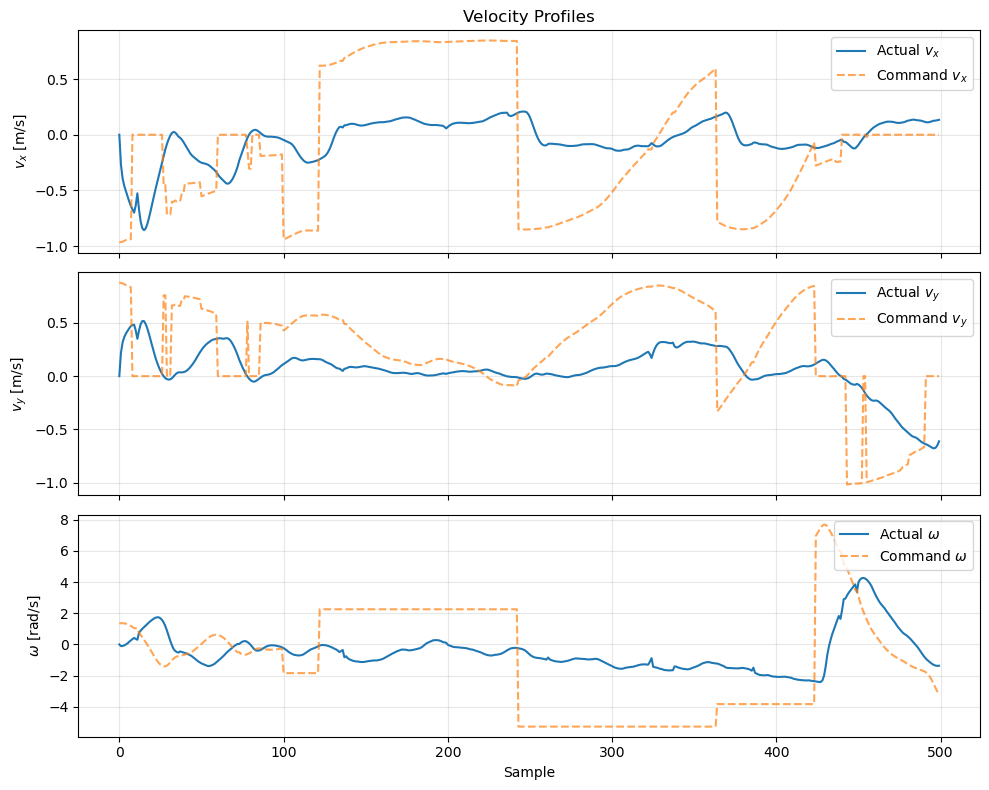

In [22]:
import matplotlib.pyplot as plt

def plot_velocity_trajectories(df):
    """
    Plots the velocity trajectories (Vx, Vy, Omega) comparing
    Actual vs Commanded values from the provided dataframe.
    """
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    
    # Plot Vx
    axes[0].plot(df.index, df['vx'], label='Actual $v_x$', linewidth=1.5)
    axes[0].plot(df.index, df['vx_cmd'], label='Command $v_x$', linestyle='--', alpha=0.7)
    axes[0].set_ylabel('$v_x$ [m/s]')
    axes[0].set_title('Velocity Profiles')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    
    # Plot Vy
    axes[1].plot(df.index, df['vy'], label='Actual $v_y$', linewidth=1.5)
    axes[1].plot(df.index, df['vy_cmd'], label='Command $v_y$', linestyle='--', alpha=0.7)
    axes[1].set_ylabel('$v_y$ [m/s]')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    # Plot Omega
    axes[2].plot(df.index, df['omega'], label='Actual $\omega$', linewidth=1.5)
    axes[2].plot(df.index, df['omega_cmd'], label='Command $\omega$', linestyle='--', alpha=0.7)
    axes[2].set_xlabel('Sample')
    axes[2].set_ylabel('$\omega$ [rad/s]')
    axes[2].legend(loc='upper right')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Usage
plot_velocity_trajectories(df[:500])

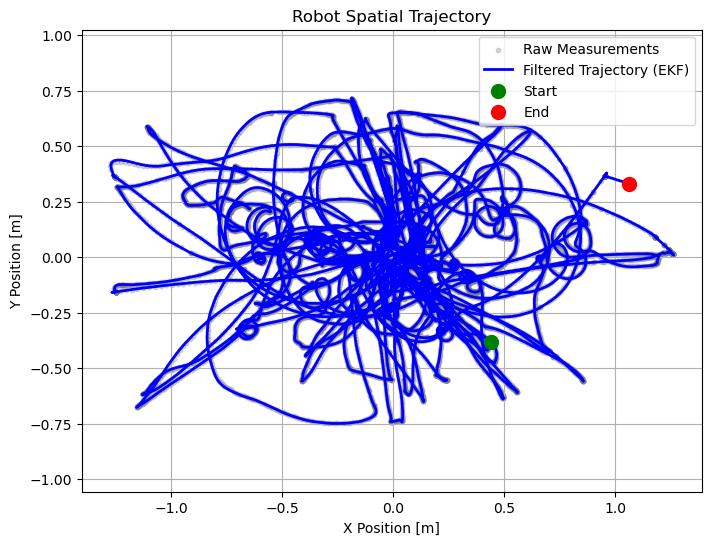

In [23]:
import matplotlib.pyplot as plt

def plot_spatial_trajectory(df):
    """
    Plots the spatial path (X vs Y) of the robot, comparing
    raw measurements with the EKF filtered trajectory.
    """
    plt.figure(figsize=(8, 6))
    
    # Plot raw measurements (noisy)
    if 'x' in df.columns and 'y' in df.columns:
        plt.scatter(df['x'], df['y'], c='gray', s=10, alpha=0.3, label='Raw Measurements')
        
    # Plot filtered trajectory (smooth)
    if 'filtered_x' in df.columns and 'filtered_y' in df.columns:
        plt.plot(df['filtered_x'], df['filtered_y'], 'b-', linewidth=2, label='Filtered Trajectory (EKF)')
        
        # Mark start and end points
        plt.scatter(df['filtered_x'].iloc[0], df['filtered_y'].iloc[0], c='green', s=100, label='Start', zorder=5)
        plt.scatter(df['filtered_x'].iloc[-1], df['filtered_y'].iloc[-1], c='red', s=100, label='End', zorder=5)

    plt.xlabel('X Position [m]')
    plt.ylabel('Y Position [m]')
    plt.title('Robot Spatial Trajectory')
    plt.axis('equal') # Important to see the true shape of the path
    plt.grid(True)
    plt.legend()
    plt.show()

# 1. Reload the dataframe using the updated function (to get x/y columns)
df = load_and_preprocess_data("train_data1.csv")

# 2. Plot the trajectory
plot_spatial_trajectory(df)

In [14]:
df.head()

,vx,vy,omega,vx_cmd,vy_cmd,omega_cmd,filtered_x,filtered_y,x,y
0,0.000000,0.000000,0.000000,1.24417,0.398825,1.34578,0.440562,-0.380633,0.440562,-0.380633
1,0.324371,0.123946,-0.109035,1.23791,0.402677,1.35987,0.432212,-0.373782,0.430273,-0.372191
2,0.469159,0.183470,-0.102240,1.23138,0.403422,1.36129,0.422404,-0.365922,0.419738,-0.363824
3,0.545435,0.217395,-0.061153,1.22127,0.399904,1.35150,0.412380,-0.358118,0.409740,-0.356200
4,0.598991,0.240277,-0.002453,1.21304,0.393702,1.33179,0.402047,-0.350163,0.399449,-0.348341


# Generate processed data

Data Processing Pipeline:

1. Filters raw CSV for specific Robot/Team and renames columns (robot_filter).
2. Applies Extended Kalman Filter (EKF) to smooth position/orientation and estimate velocities (ekf_filter).
3. Transforms local velocities (command velocities) to the robot's global frame(camera).
4. Cleans infinitesimal values and returns a DataFrame with kinematic states and commands.
df = load_and_preprocess_data("train_data1.csv")

In [25]:
files_path = ['test_data1.csv', 'train_data1.csv', 'train_data2.csv']
i = 0
for f in files_path:
    save_df = load_and_preprocess_data(f)
    save_df.to_csv(f'data{i}.csv')
    i += 1